In [17]:
from drivecycle import route, simplification, plots
import pandas as pd

In [2]:
df = pd.read_json("../tests/data/calgary-1.json")

In [27]:
df1 = simplification.cluster_nodes(df,20)
df1

,speed,end,lr
0,4.17,"[bus_stop, service_other, service_other, terti...",20.02
1,11.11,[service_other],82.00
2,11.11,"[residential, bus_stop]",223.50
3,11.11,[residential],357.00
4,11.11,[residential],435.00
...,...,...,...
221,8.33,[bus_stop],24205.00
222,8.33,[residential],24268.00
223,8.33,"[service_other, residential]",24353.00
224,5.56,[residential],24430.00


In [24]:
stop_params = {
    "bus_stop":60,
    "tertiary":120,
    "secondary":180,
}
tvq = route.sequential(df1,stop_params, step=2, a_max=2)

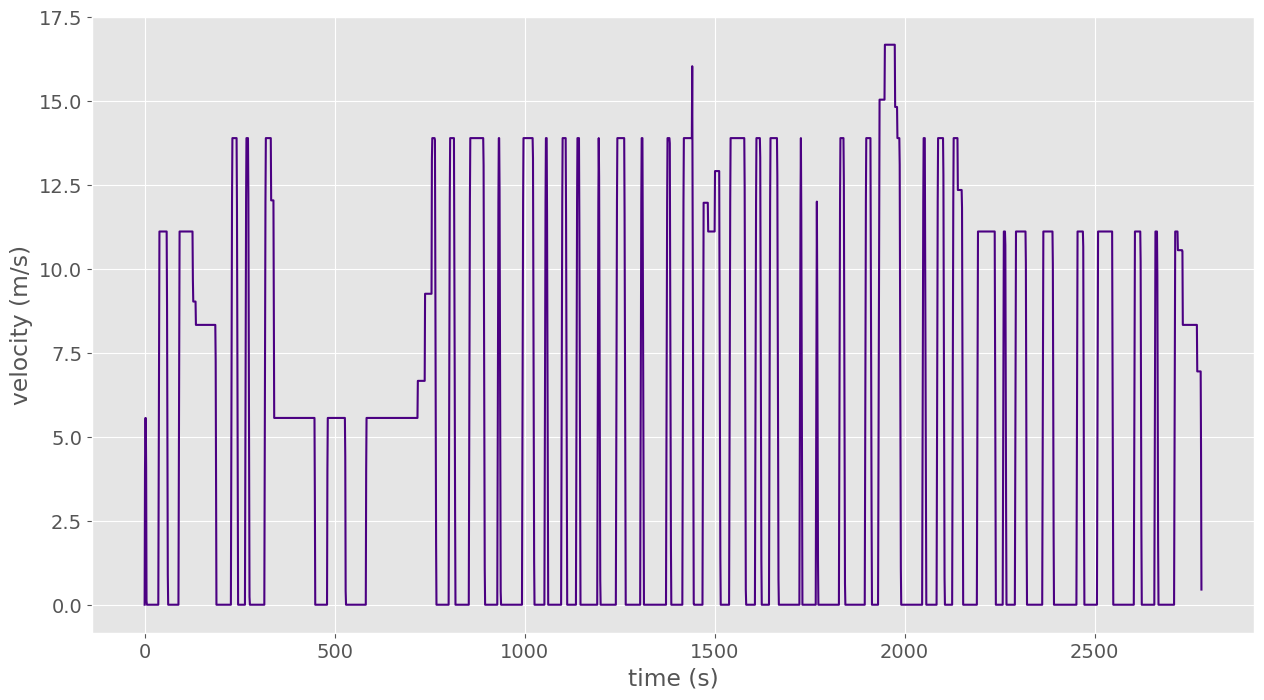

In [25]:
plots.plot_vt(tvq,"test3.png")